In [2]:
# ============= IMPORTS AND SETUP =============
import sys
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pandas as pd
from scipy import signal, stats
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# ============= CONFIGURATION SECTION =============
# Base paths
BASE_PATH = Path("/project/cc-20250120231604/ssd/users/kwsu/research/dsllm/dsllm/data")
MODEL_BASE_PATH = "/project/cc-20250120231604/ssd/users/kwsu/data/trained_model/enhancement_model"

# Data Configuration
DS_CONFIG = {
    'high_res_ds': '100DS',    # Target sampling rate
    'low_res_ds': '500DS',    # Input sampling rate
    'upsampling_factor': 5,   # From 1000DS to 100DS
    'sequence_length': '300seconds'
}

# Construct data paths
HIGH_RES_PATH = str(BASE_PATH / f"stage_2_compare_buffer/{DS_CONFIG['sequence_length']}_{DS_CONFIG['high_res_ds']}/test/capture24_test_data_stage2_{DS_CONFIG['sequence_length']}_{DS_CONFIG['high_res_ds']}.pkl")
LOW_RES_PATH = str(BASE_PATH / f"stage_2_compare_buffer/{DS_CONFIG['sequence_length']}_{DS_CONFIG['low_res_ds']}/test/capture24_test_data_stage2_{DS_CONFIG['sequence_length']}_{DS_CONFIG['low_res_ds']}.pkl")

# Model path
MODEL_PATH = f"{MODEL_BASE_PATH}/constrained_enhancement_model_5x_v0.pth"

# Model Configuration
MODEL_CONFIG = {
    'high_res_timesteps': 300,
    'low_res_timesteps': 300 // DS_CONFIG['upsampling_factor'],  # Automatically calculated
    'feature_dim': 3,
    'teacher_hidden_dim': 512,
    'student_hidden_dim': 256,
    'batch_size': 16
}

# ============= IMPORTS AND SETUP =============
import sys
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pandas as pd
from scipy import signal, stats
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("📊 Data Enhancement Model Evaluation")
print("=====================================")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print("\n📂 Configuration:")
print(f"High-res data: {DS_CONFIG['high_res_ds']}")
print(f"Low-res data: {DS_CONFIG['low_res_ds']}")
print(f"Upsampling factor: {DS_CONFIG['upsampling_factor']}x")
print(f"Model path: {MODEL_PATH}")


📊 Data Enhancement Model Evaluation
PyTorch version: 2.6.0+cu118
CUDA available: True

📂 Configuration:
High-res data: 100DS
Low-res data: 500DS
Upsampling factor: 5x
Model path: /project/cc-20250120231604/ssd/users/kwsu/data/trained_model/enhancement_model/constrained_enhancement_model_5x_v0.pth


In [3]:
# Import our models
current_dir = Path().absolute()
if str(current_dir) not in sys.path:
    sys.path.append(str(current_dir))

from teacher_student_model import DataEnhancementTeacherStudentModel, DataEnhancementConfig


In [4]:
# Load configuration and model
import yaml

# Create model configuration
config = DataEnhancementConfig(
    high_res_path=HIGH_RES_PATH,
    low_res_path=LOW_RES_PATH,
    high_res_timesteps=MODEL_CONFIG['high_res_timesteps'],
    low_res_timesteps=MODEL_CONFIG['low_res_timesteps'],
    feature_dim=MODEL_CONFIG['feature_dim'],
    teacher_hidden_dim=MODEL_CONFIG['teacher_hidden_dim'],
    student_hidden_dim=MODEL_CONFIG['student_hidden_dim'],
    batch_size=MODEL_CONFIG['batch_size'],
    device="cuda" if torch.cuda.is_available() else "cpu")

print(f"📂 Data paths:")
print(f"   High-res: {config.high_res_path}")
print(f"   Low-res: {config.low_res_path}")
print(f"   Device: {config.device}")


📂 Data paths:
   High-res: /project/cc-20250120231604/ssd/users/kwsu/research/dsllm/dsllm/data/stage_2_compare_buffer/300seconds_100DS/test/capture24_test_data_stage2_300seconds_100DS.pkl
   Low-res: /project/cc-20250120231604/ssd/users/kwsu/research/dsllm/dsllm/data/stage_2_compare_buffer/300seconds_500DS/test/capture24_test_data_stage2_300seconds_500DS.pkl
   Device: cuda


In [5]:
# Initialize model and load trained weights
print("🏗️  Loading trained model...")

# Initialize model with the config
from run_data_enhancement_constrained import ConstrainedEnhancementModel
model = ConstrainedEnhancementModel(config).to(config.device)

# Load the trained model
print(f"Loading model from: {MODEL_PATH}")
checkpoint = torch.load(MODEL_PATH, map_location=config.device, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])

# Set to evaluation mode
model.eval()

print("✅ Model loaded successfully!")

# Load and prepare datasets
import pickle
import numpy as np
print("\n📊 Loading datasets...")
with open(HIGH_RES_PATH, 'rb') as f:
    high_res_data = pickle.load(f)
with open(LOW_RES_PATH, 'rb') as f:
    low_res_data = pickle.load(f)

# Convert lists to numpy arrays
high_res_data = np.array(high_res_data)
low_res_data = np.array(low_res_data)

print(f"   High-res data shape: {high_res_data.shape}")
print(f"   Low-res data shape: {low_res_data.shape}")
print(f"   Number of samples: {len(high_res_data)}")

# Create evaluation output folder with timestamp
import datetime
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
eval_output_dir = Path(f"evaluation/eval_run_{timestamp}")
eval_output_dir.mkdir(parents=True, exist_ok=True)
print(f"\n📁 Evaluation outputs will be saved to: {eval_output_dir}")


🏗️  Loading trained model...
Loading model from: /project/cc-20250120231604/ssd/users/kwsu/data/trained_model/enhancement_model/constrained_enhancement_model_5x_v0.pth
✅ Model loaded successfully!

📊 Loading datasets...
   High-res data shape: (9704, 300, 3)
   Low-res data shape: (9704, 60, 3)
   Number of samples: 9704

📁 Evaluation outputs will be saved to: evaluation/eval_run_20250703_163100


In [6]:
# Create dataset and dataloader
from torch.utils.data import TensorDataset, DataLoader

# Convert numpy arrays to torch tensors if they aren't already
low_res_tensor = torch.FloatTensor(low_res_data)
high_res_tensor = torch.FloatTensor(high_res_data)

# Create dataset and dataloader
dataset = TensorDataset(low_res_tensor, high_res_tensor)
dataloader = DataLoader(dataset, batch_size=config.batch_size, shuffle=False)

# Generate predictions on entire test set
print("🔮 Generating predictions on test set...")

all_low_res = []
all_high_res = []
all_enhanced = []

with torch.no_grad():
    for batch_idx, (low_res_batch, high_res_batch) in enumerate(dataloader):
        if batch_idx % 10 == 0:
            print(f"Processing batch {batch_idx}/{len(dataloader)}")
            
        low_res_batch = low_res_batch.to(config.device)
        high_res_batch = high_res_batch.to(config.device)
        
        # Generate enhanced data using the constrained model
        enhanced_batch = model(low_res_batch)
        
        # Store results
        all_low_res.append(low_res_batch.cpu().numpy())
        all_high_res.append(high_res_batch.cpu().numpy())
        all_enhanced.append(enhanced_batch.cpu().numpy())

# Concatenate all batches
all_low_res = np.concatenate(all_low_res, axis=0)
all_high_res = np.concatenate(all_high_res, axis=0)
enhanced_data = np.concatenate(all_enhanced, axis=0)

print(f"✅ Generated predictions for {len(enhanced_data)} test samples")
print(f"   Low-res shape: {all_low_res.shape}")
print(f"   High-res shape: {all_high_res.shape}")
print(f"   Enhanced shape: {enhanced_data.shape}")
print(f"   High-res shape: {high_res_data.shape}")
print(f"   Enhanced shape: {enhanced_data.shape}")


🔮 Generating predictions on test set...
Processing batch 0/607
Processing batch 10/607
Processing batch 20/607
Processing batch 30/607
Processing batch 40/607
Processing batch 50/607
Processing batch 60/607
Processing batch 70/607
Processing batch 80/607
Processing batch 90/607
Processing batch 100/607
Processing batch 110/607
Processing batch 120/607
Processing batch 130/607
Processing batch 140/607
Processing batch 150/607
Processing batch 160/607
Processing batch 170/607
Processing batch 180/607
Processing batch 190/607
Processing batch 200/607
Processing batch 210/607
Processing batch 220/607
Processing batch 230/607
Processing batch 240/607
Processing batch 250/607
Processing batch 260/607
Processing batch 270/607
Processing batch 280/607
Processing batch 290/607
Processing batch 300/607
Processing batch 310/607
Processing batch 320/607
Processing batch 330/607
Processing batch 340/607
Processing batch 350/607
Processing batch 360/607
Processing batch 370/607
Processing batch 380/

In [7]:
# Calculate comprehensive metrics
print("📈 Computing performance metrics...")

def compute_metrics(true_data, pred_data):
    """Compute comprehensive evaluation metrics"""
    # Flatten for global metrics
    true_flat = true_data.reshape(-1)
    pred_flat = pred_data.reshape(-1)
    
    metrics = {
        'MSE': mean_squared_error(true_flat, pred_flat),
        'RMSE': np.sqrt(mean_squared_error(true_flat, pred_flat)),
        'MAE': mean_absolute_error(true_flat, pred_flat),
        'R²': r2_score(true_flat, pred_flat),
        'Pearson_r': stats.pearsonr(true_flat, pred_flat)[0],
        'MAPE': np.mean(np.abs((true_flat - pred_flat) / (true_flat + 1e-8))) * 100,
        'SNR_dB': 10 * np.log10(np.var(true_flat) / np.var(true_flat - pred_flat))
    }
    
    return metrics

# Overall metrics
overall_metrics = compute_metrics(high_res_data, enhanced_data)

print("\n🎯 Overall Performance Metrics:")
print("=" * 40)
for metric, value in overall_metrics.items():
    print(f"{metric:12s}: {value:.6f}")

# Per-axis metrics
axis_names = ['X-axis', 'Y-axis', 'Z-axis']
axis_metrics = {}

for i, axis_name in enumerate(axis_names):
    axis_metrics[axis_name] = compute_metrics(
        high_res_data[:, :, i], 
        enhanced_data[:, :, i]
    )

print("\n📊 Per-Axis Performance:")
print("=" * 50)
df_metrics = pd.DataFrame(axis_metrics).T
print(df_metrics.round(6))


📈 Computing performance metrics...

🎯 Overall Performance Metrics:
MSE         : 0.040323
RMSE        : 0.200805
MAE         : 0.099116
R²          : 0.883266
Pearson_r   : 0.941402
MAPE        : 343399.200503
SNR_dB      : 9.412625

📊 Per-Axis Performance:
             MSE      RMSE       MAE        R²  Pearson_r           MAPE  \
X-axis  0.037056  0.192499  0.095010  0.911842   0.956636  424852.882375   
Y-axis  0.043517  0.208608  0.110237  0.822111   0.913529  340432.174506   
Z-axis  0.040395  0.200984  0.092101  0.874255   0.935210  264912.544628   

           SNR_dB  
X-axis  10.697425  
Y-axis   7.802227  
Z-axis   9.008990  



📊 Raw labels sample:
First label structure: {'activity_category': 1, 'subject': 'P112', 'window_indices': [0, 29999], 'window_id': ('P112', 0, 29999), 'activity_name': 'sleep'}
Label type: <class 'dict'>
Total labels: 9704

📊 Unique activities found: [ 1  2  3  4  5  6  7  8  9 10]

📊 Found activities:
   Activity Category 1 (sleep): sample #0
   Activity Category 2 (sitting): sample #75
   Activity Category 3 (standing): sample #392
   Activity Category 4 (walking): sample #72
   Activity Category 5 (bicycling): sample #73
   Activity Category 6 (vehicle): sample #728
   Activity Category 7 (household-chores): sample #292
   Activity Category 8 (manual-work): sample #1806
   Activity Category 9 (sports): sample #1524
   Activity Category 10 (mixed-activity): sample #128

🖼️  Generating reconstruction visualizations for each activity...

   Activity Category 1 (sleep)
   Saved figure to evaluation/eval_run_20250703_163100/reconstruction_sample_0.png


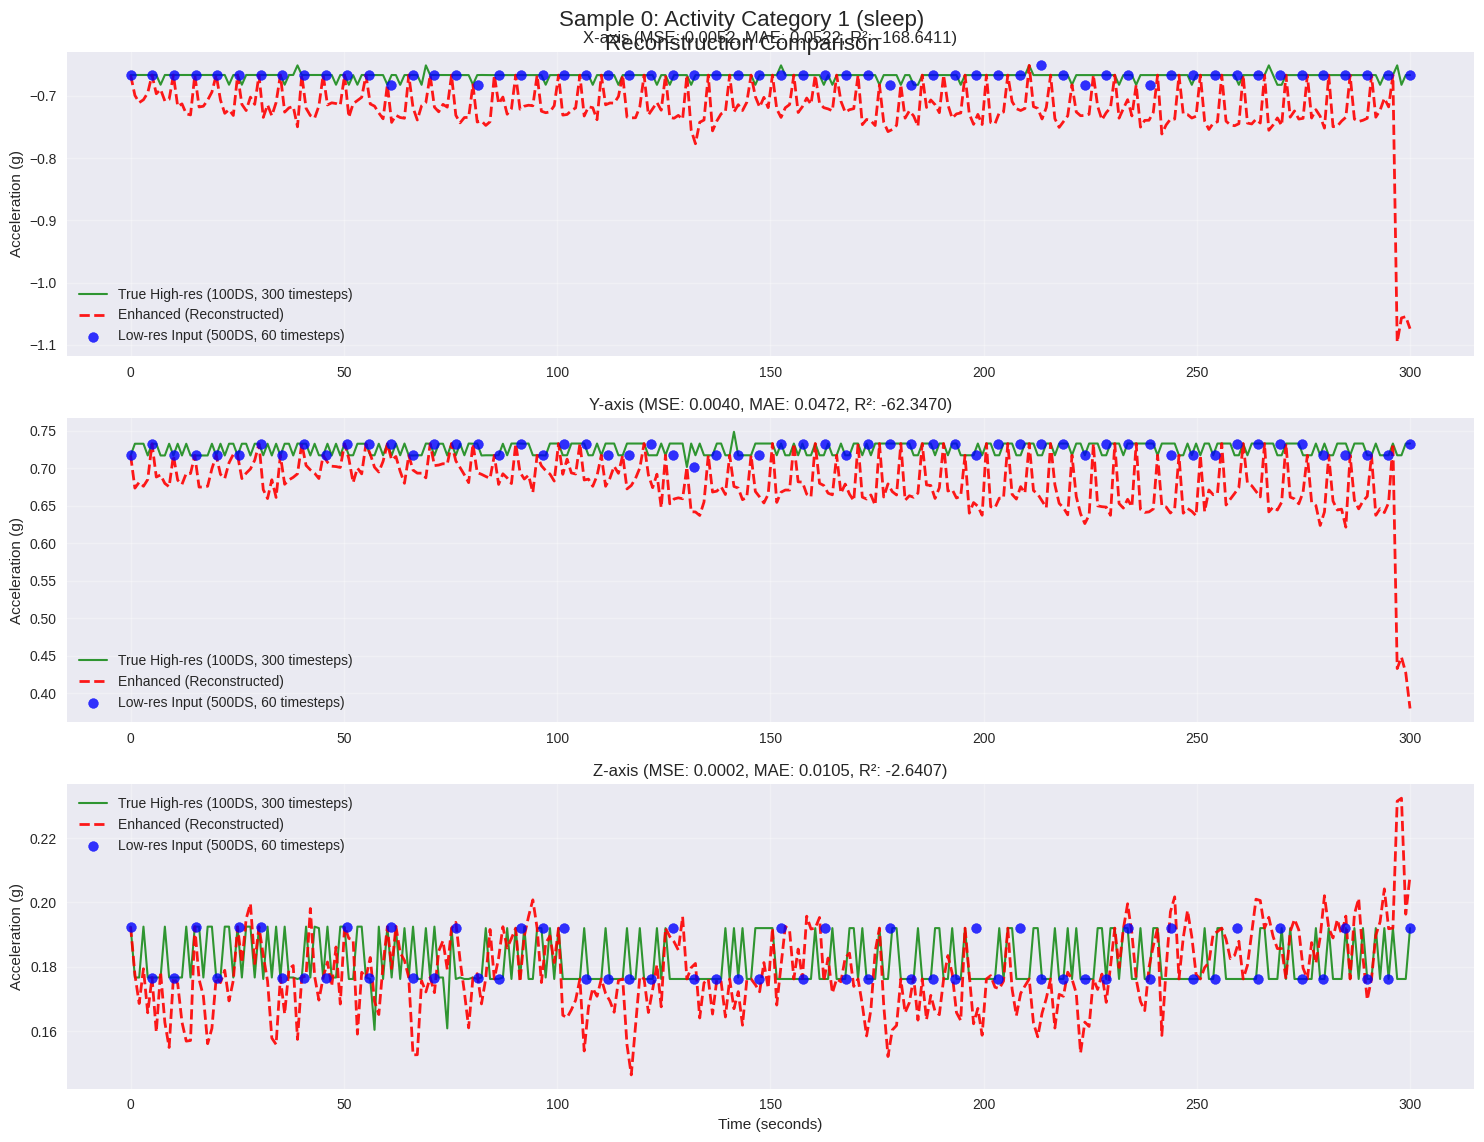


   Activity Category 2 (sitting)
   Saved figure to evaluation/eval_run_20250703_163100/reconstruction_sample_75.png


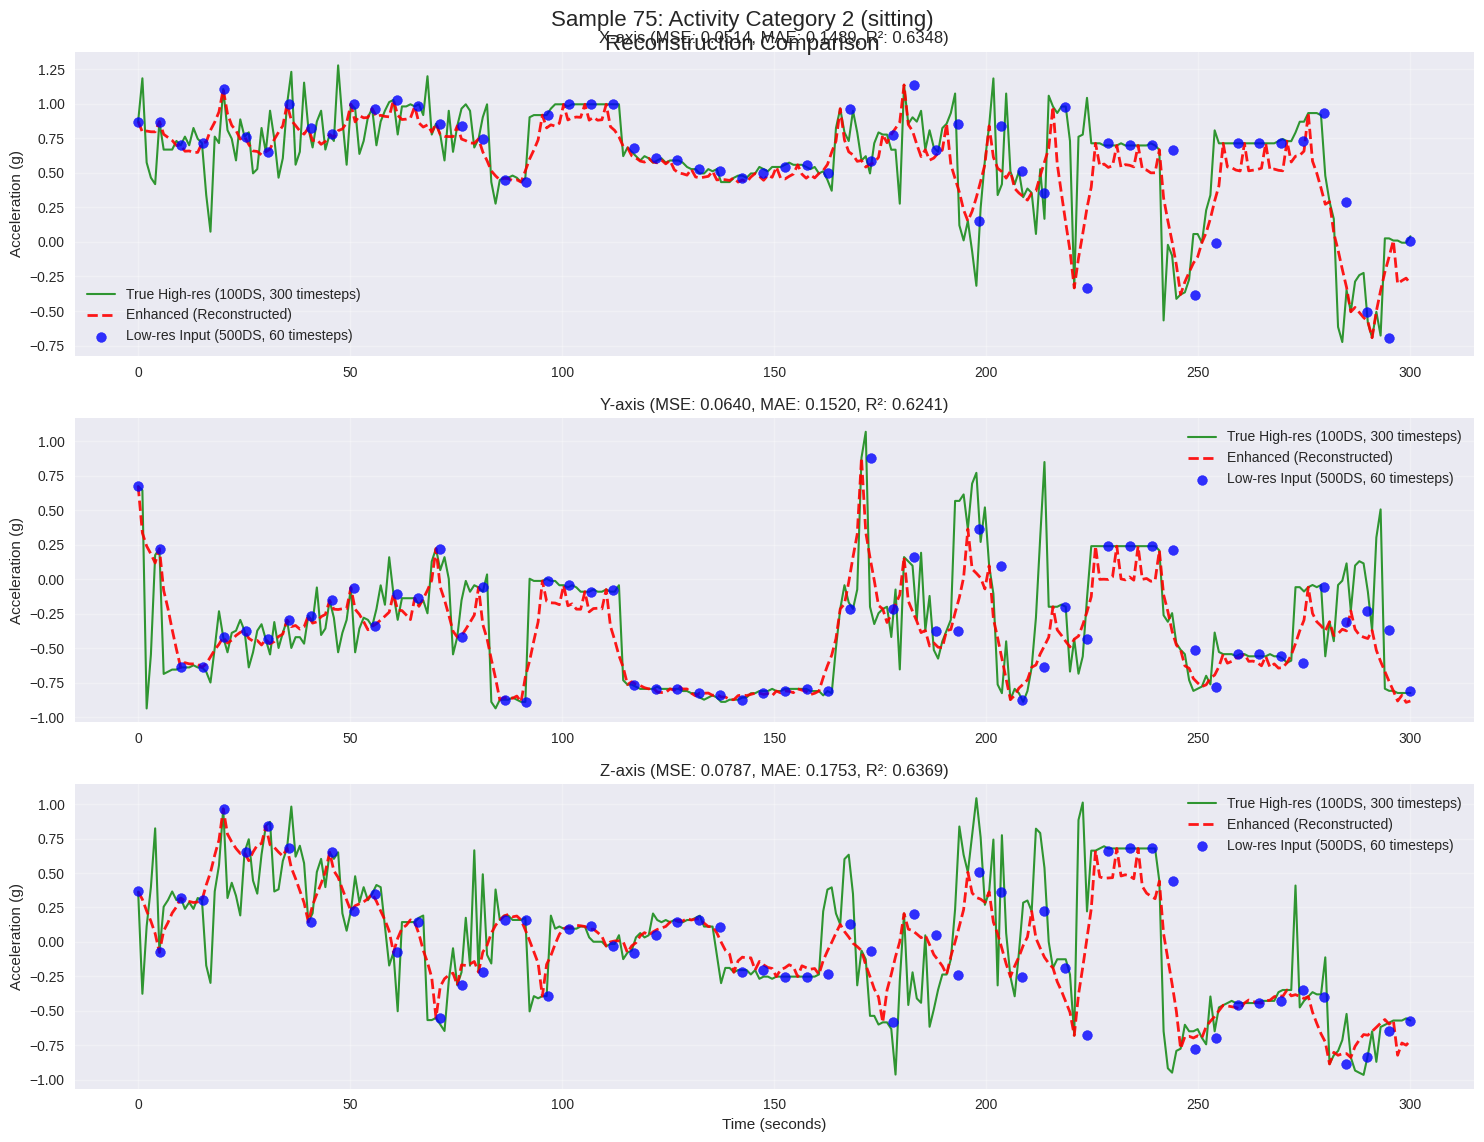


   Activity Category 3 (standing)
   Saved figure to evaluation/eval_run_20250703_163100/reconstruction_sample_392.png


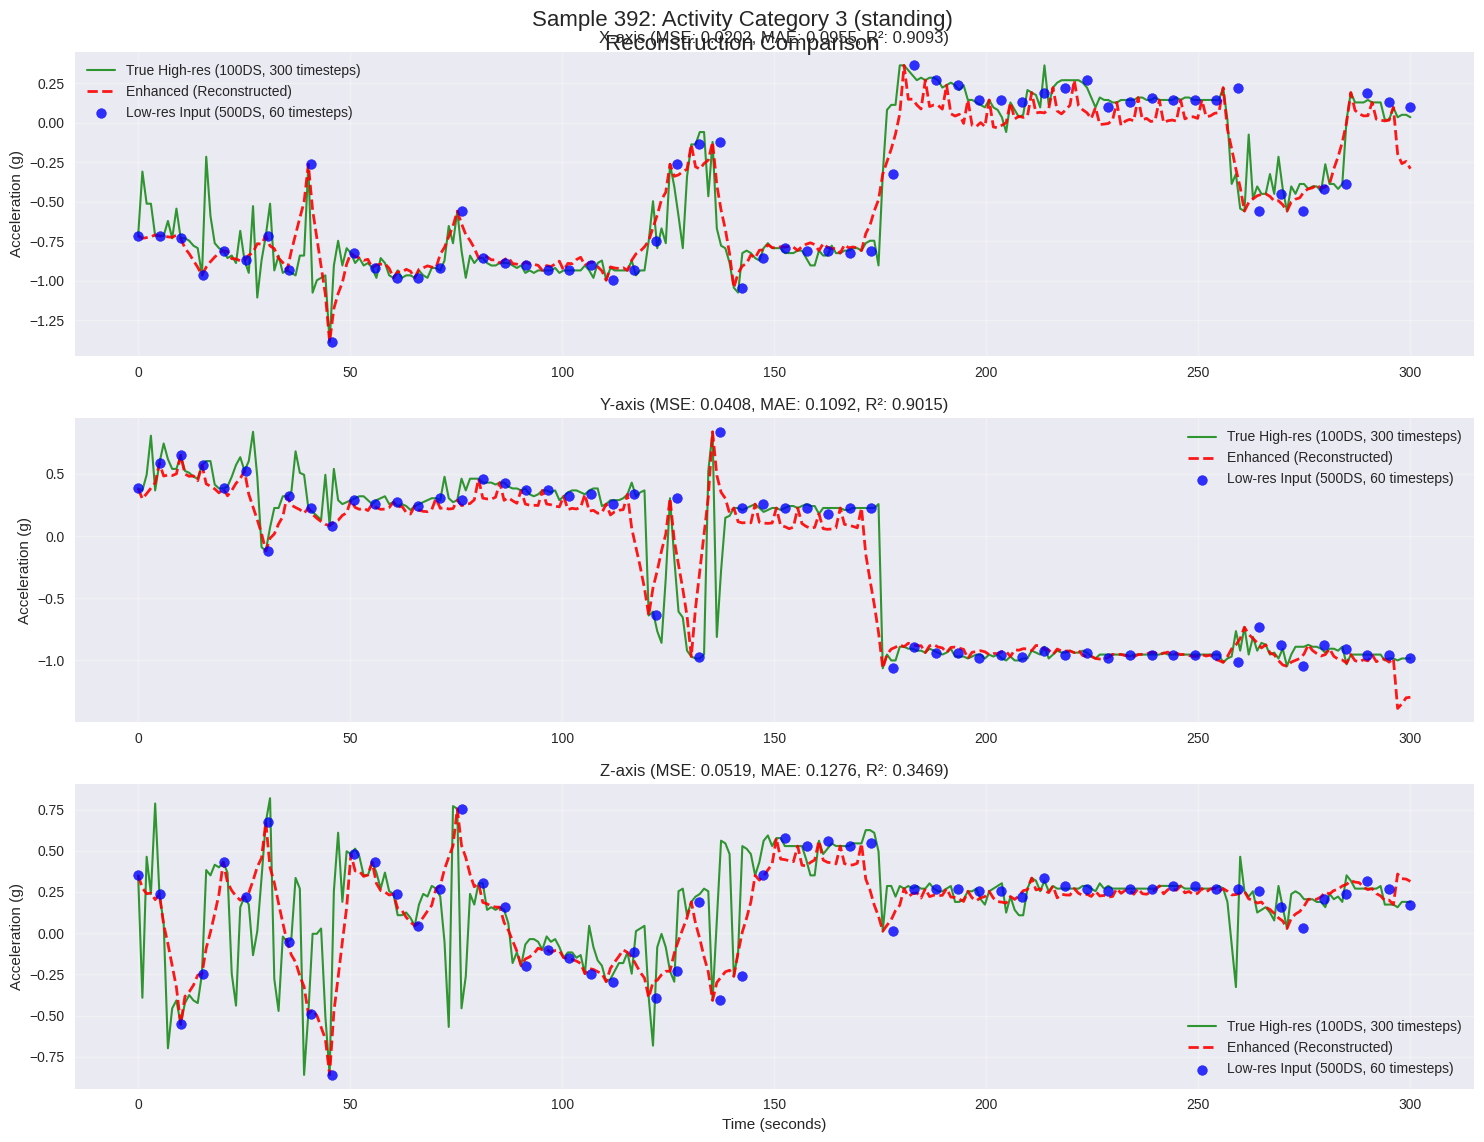


   Activity Category 4 (walking)
   Saved figure to evaluation/eval_run_20250703_163100/reconstruction_sample_72.png


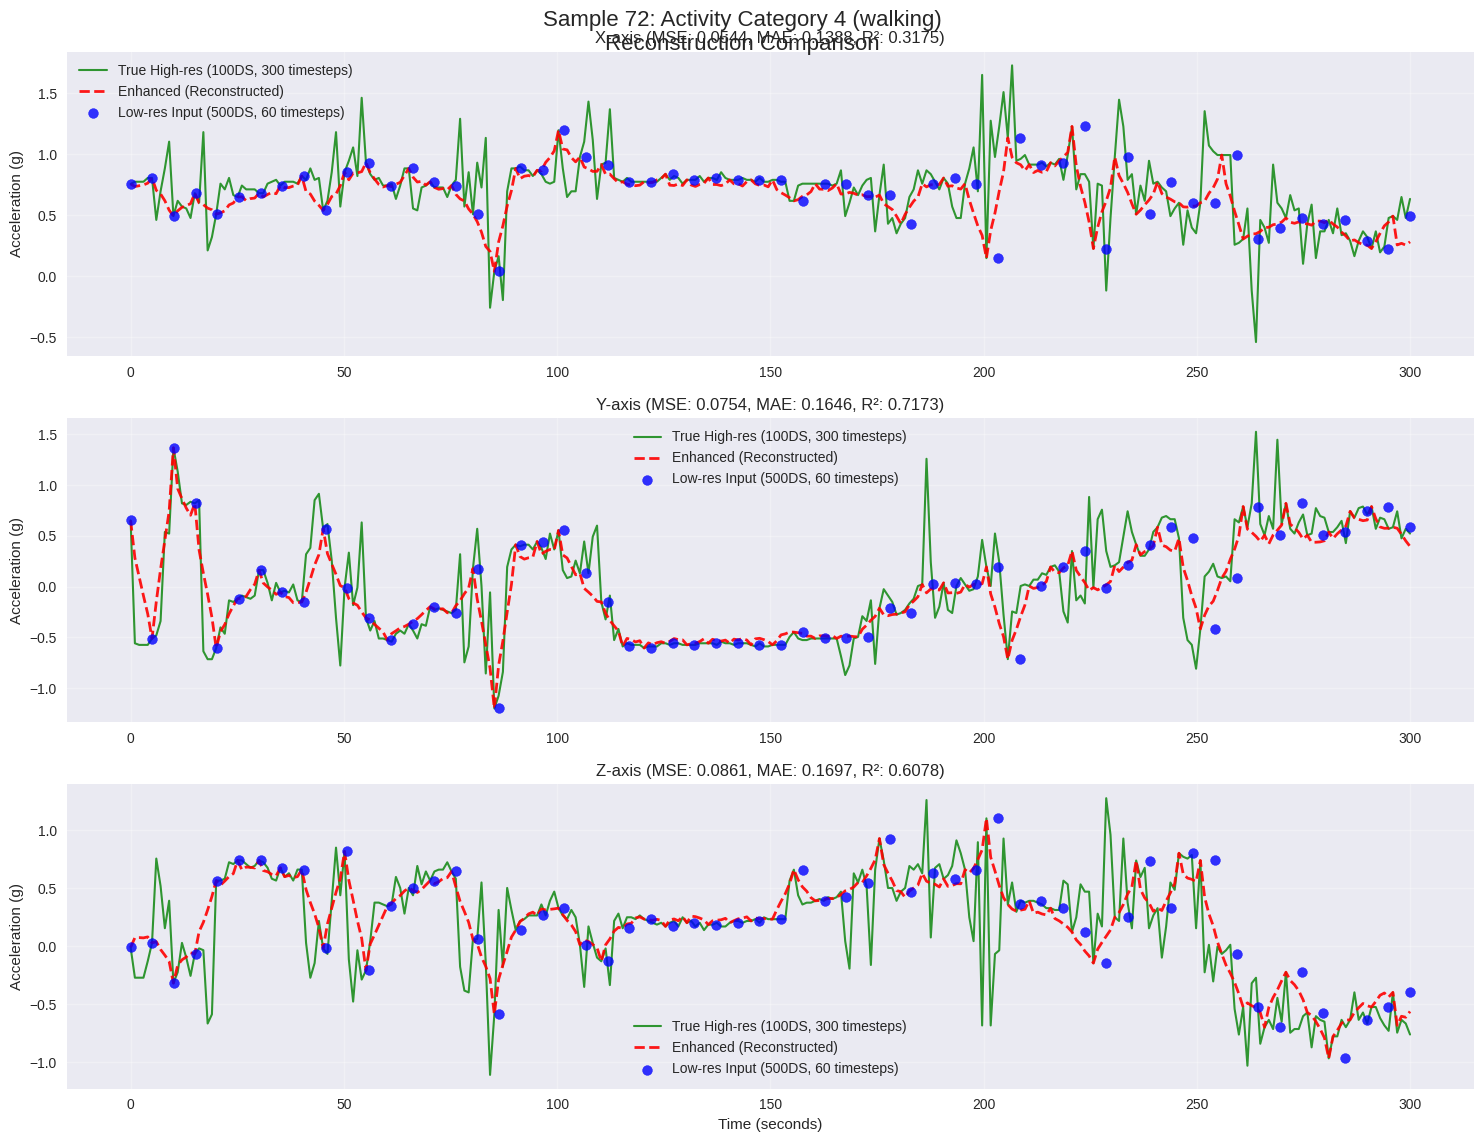


   Activity Category 5 (bicycling)
   Saved figure to evaluation/eval_run_20250703_163100/reconstruction_sample_73.png


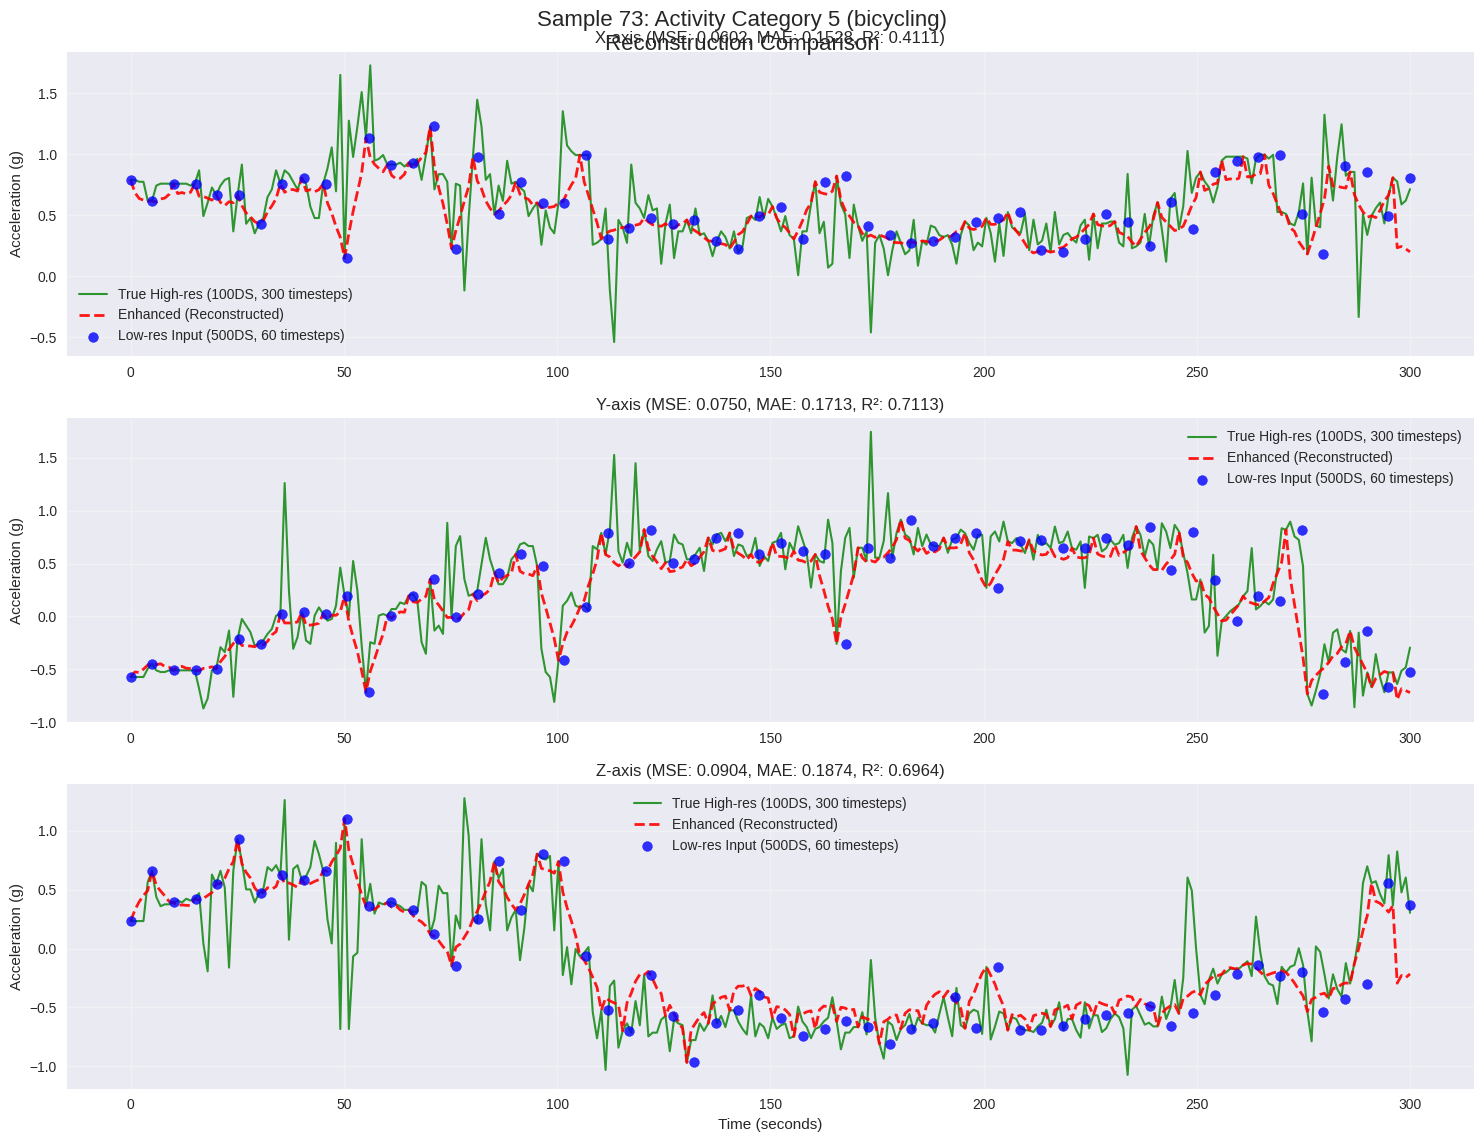


   Activity Category 6 (vehicle)
   Saved figure to evaluation/eval_run_20250703_163100/reconstruction_sample_728.png


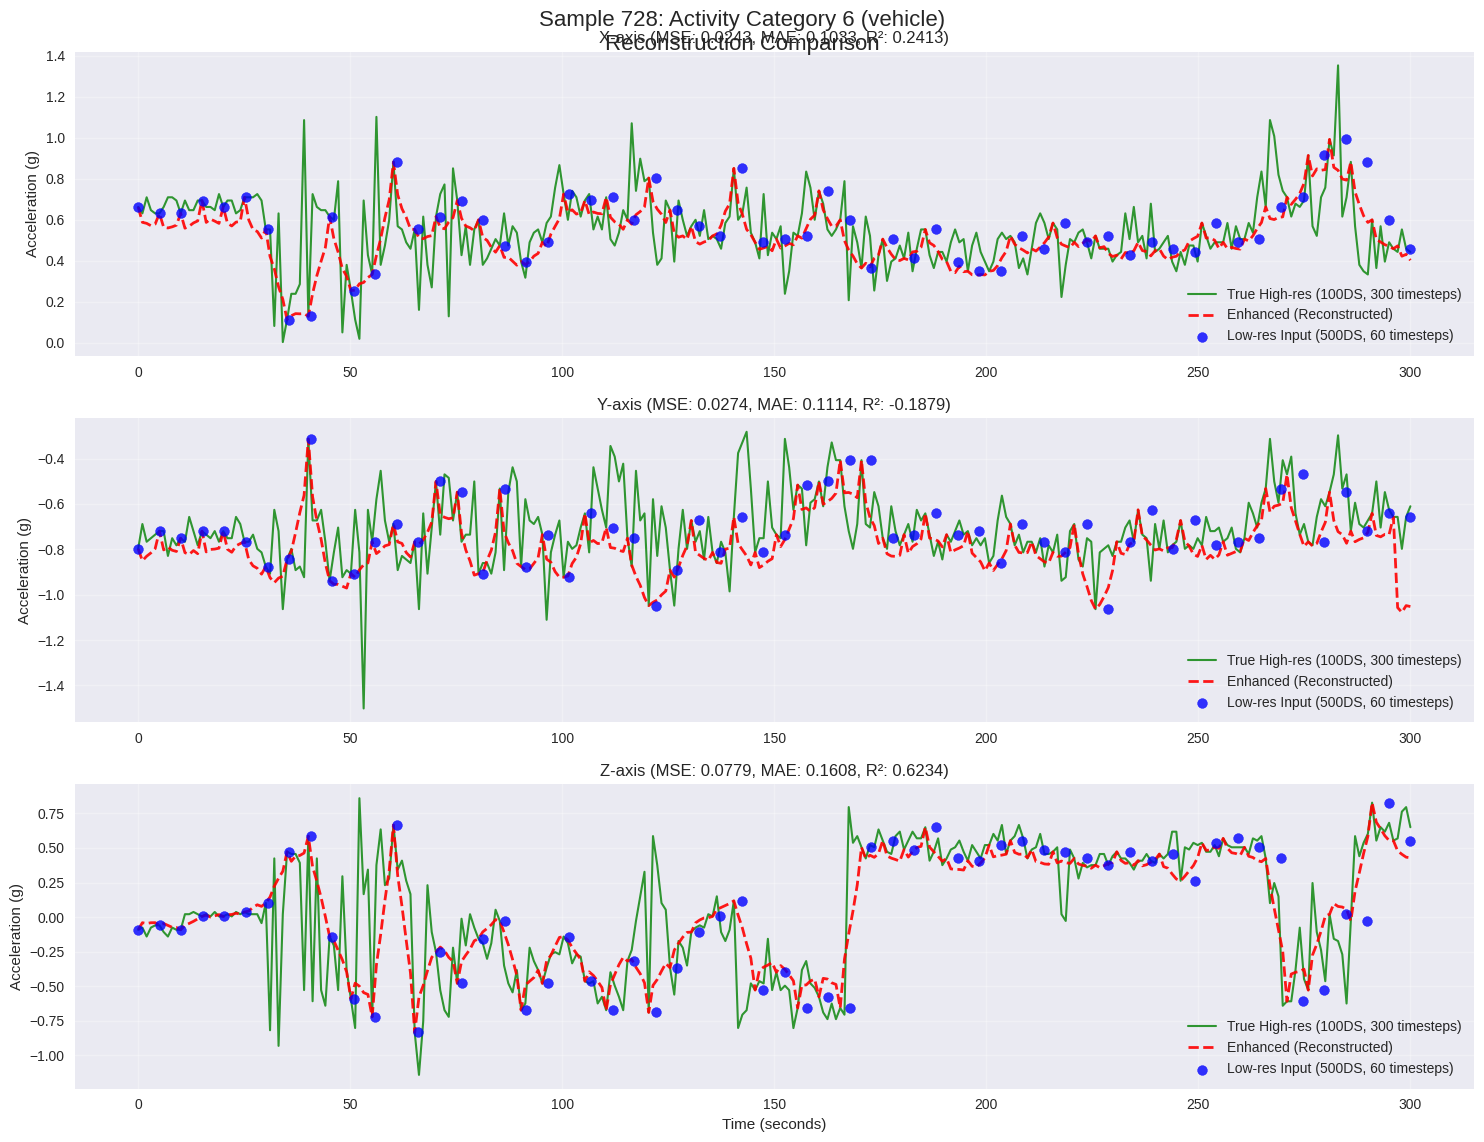


   Activity Category 7 (household-chores)
   Saved figure to evaluation/eval_run_20250703_163100/reconstruction_sample_292.png


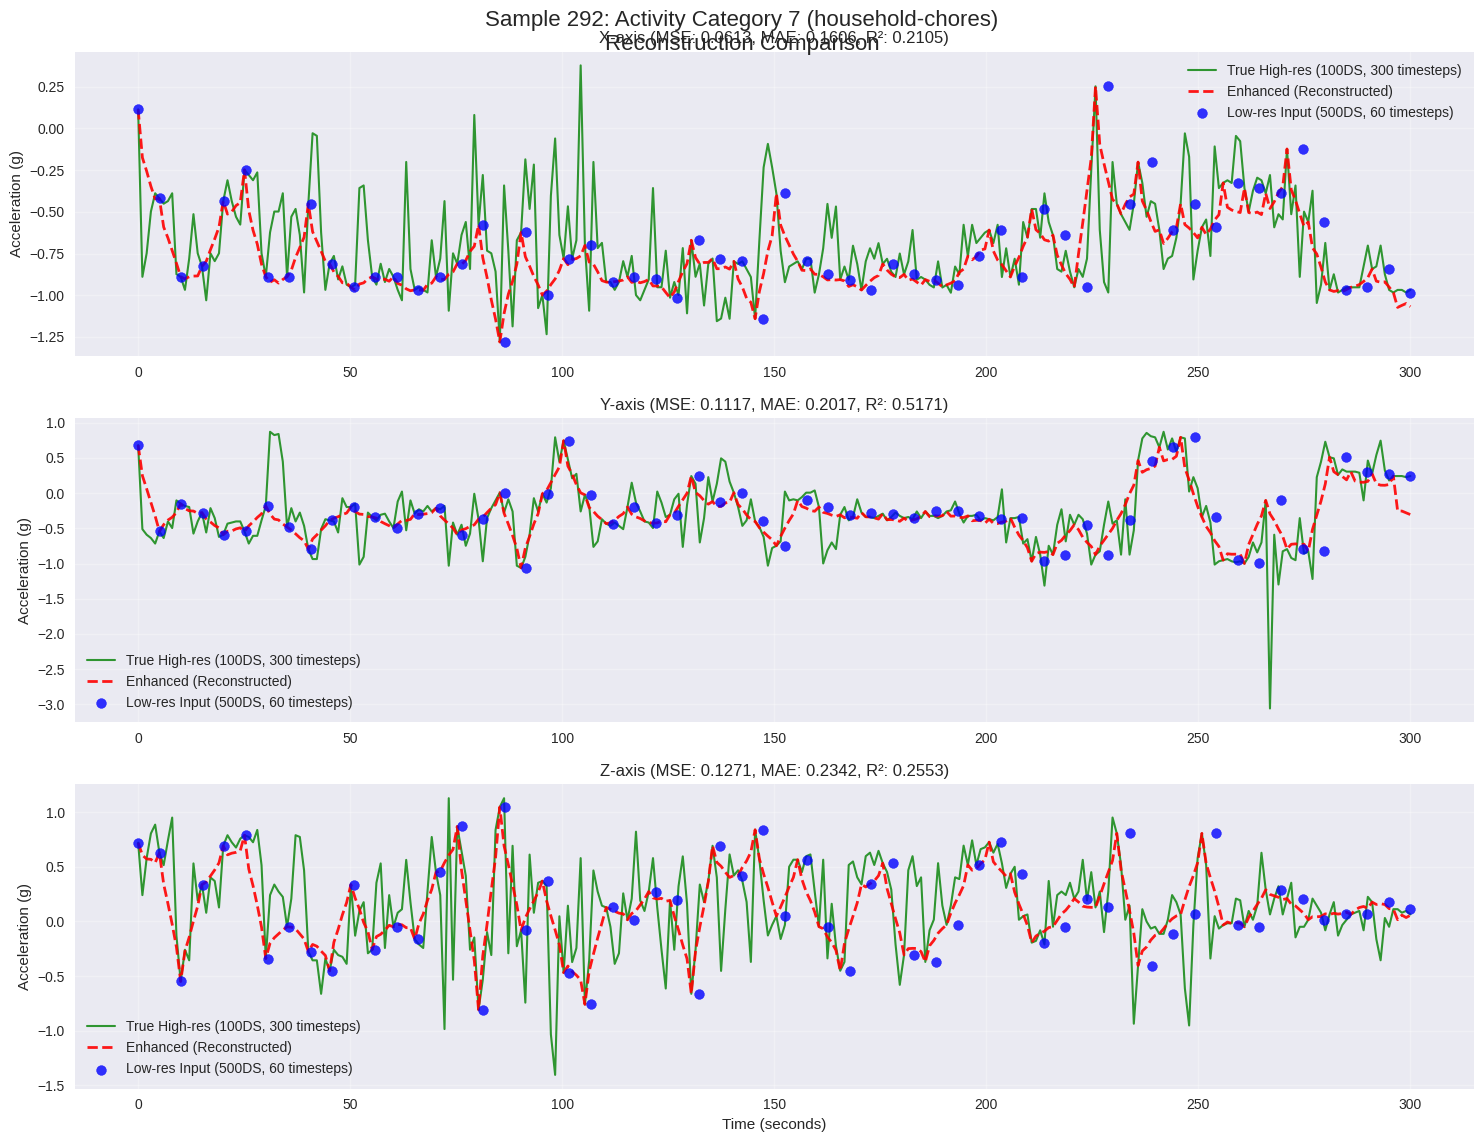


   Activity Category 8 (manual-work)
   Saved figure to evaluation/eval_run_20250703_163100/reconstruction_sample_1806.png


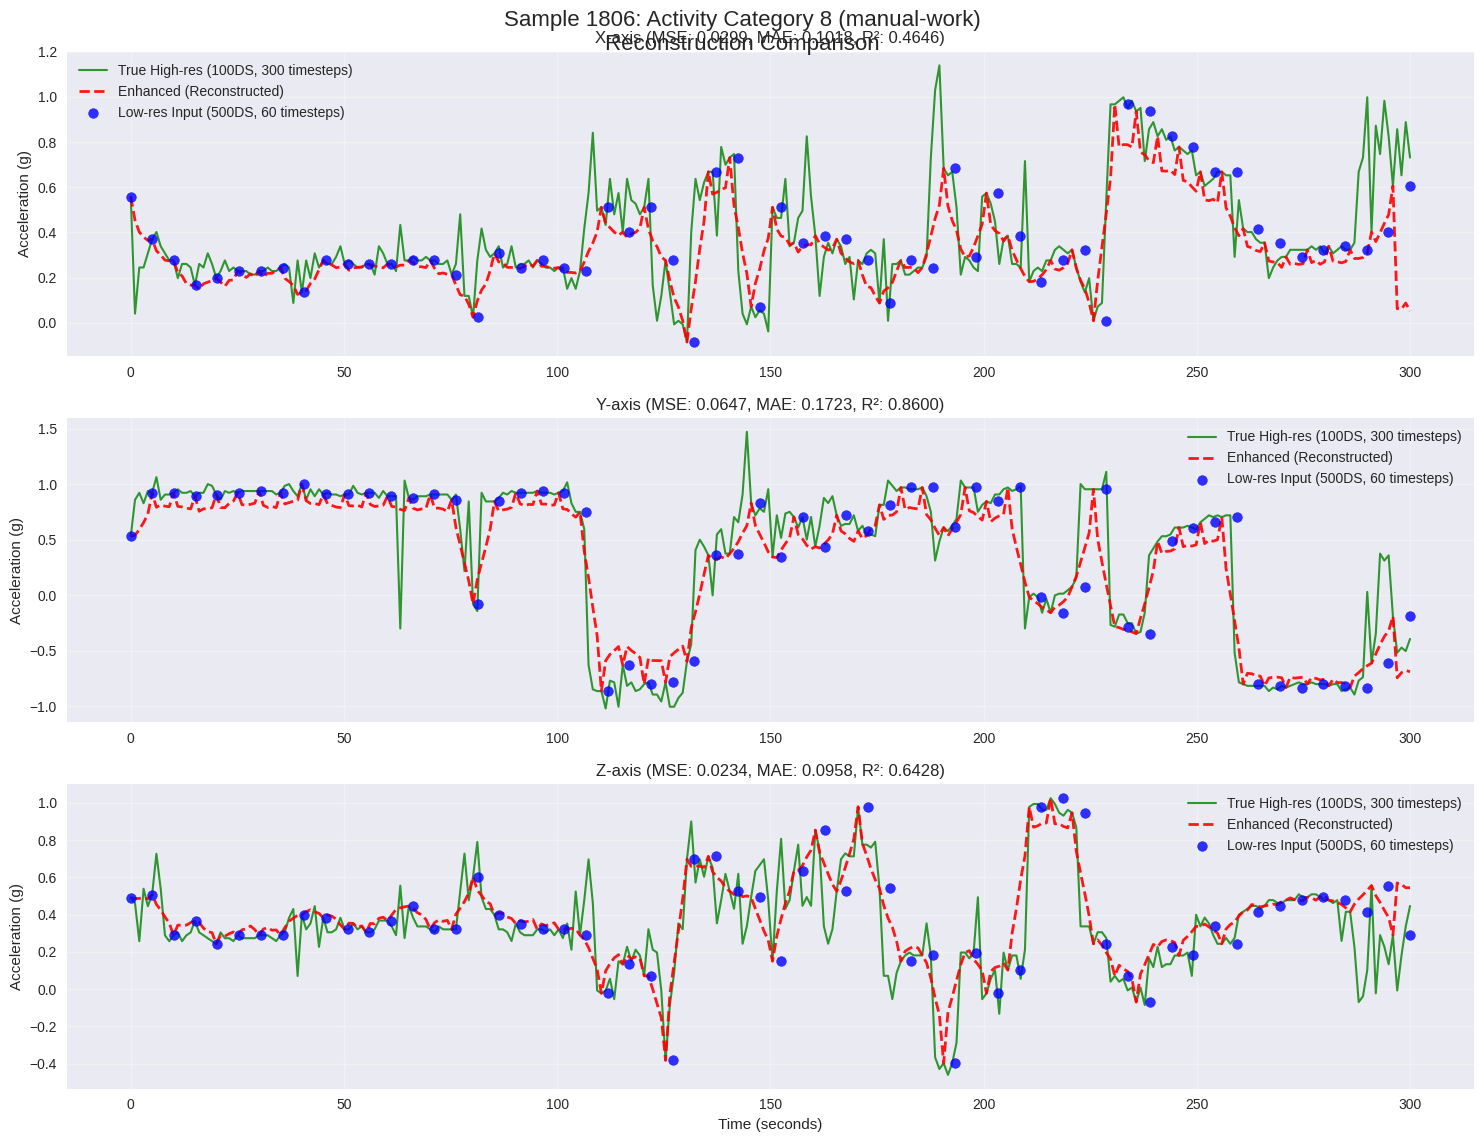


   Activity Category 9 (sports)
   Saved figure to evaluation/eval_run_20250703_163100/reconstruction_sample_1524.png


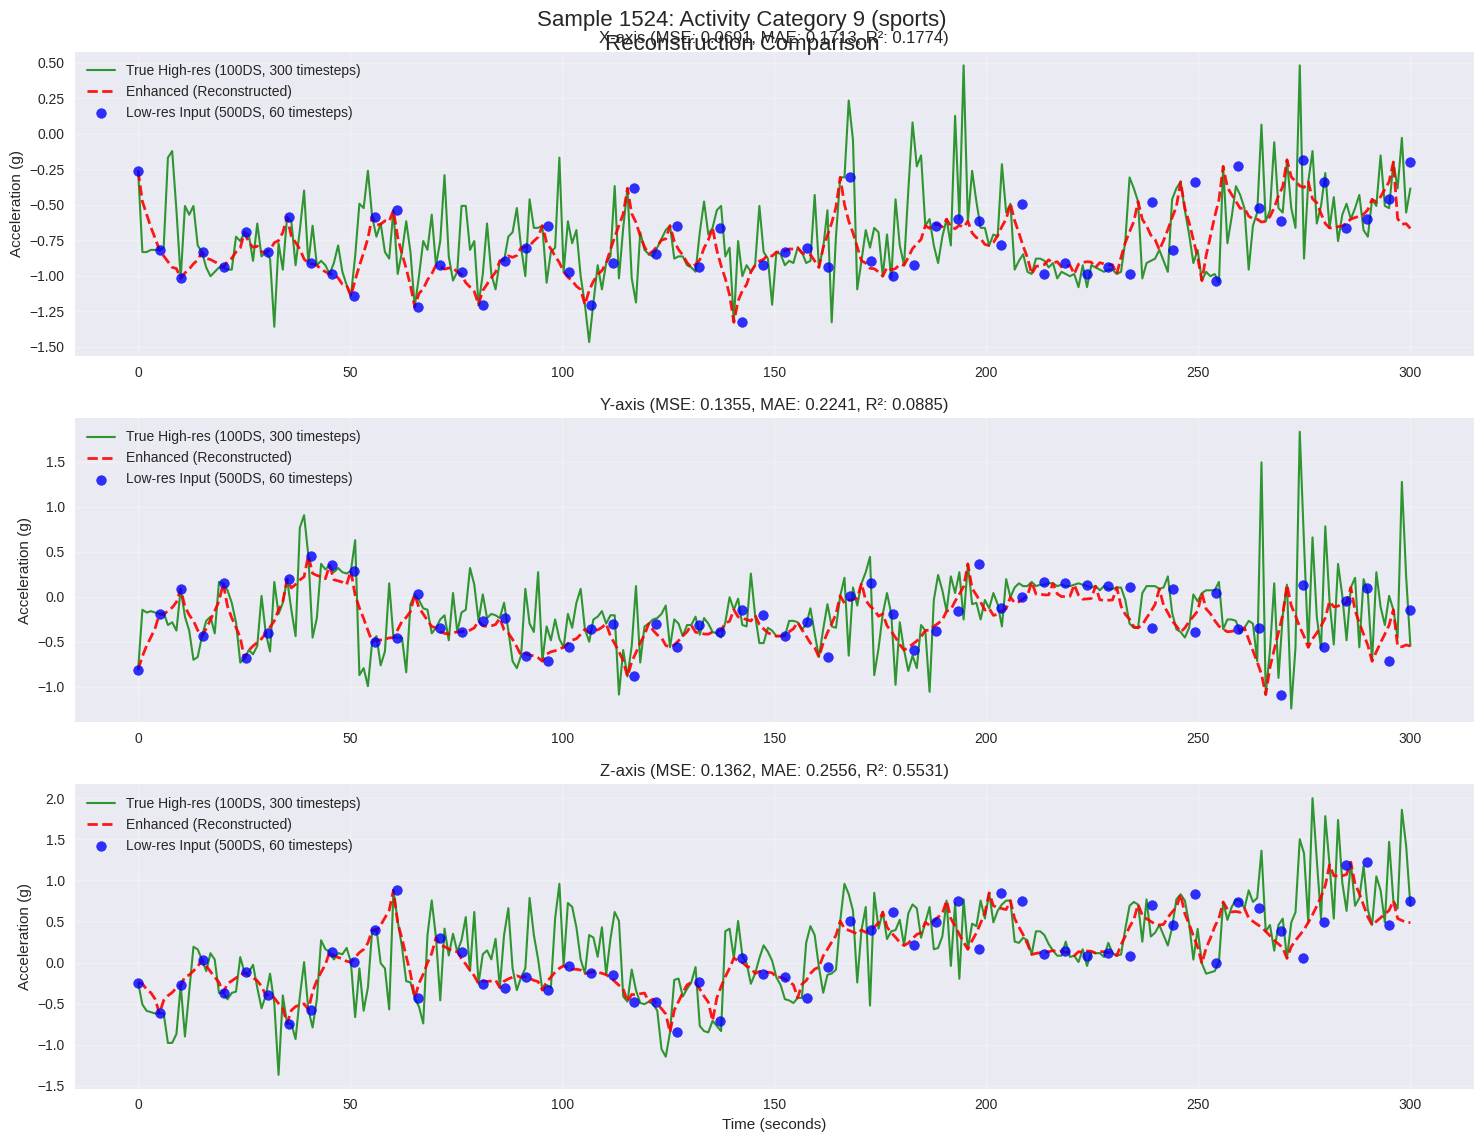


   Activity Category 10 (mixed-activity)
   Saved figure to evaluation/eval_run_20250703_163100/reconstruction_sample_128.png


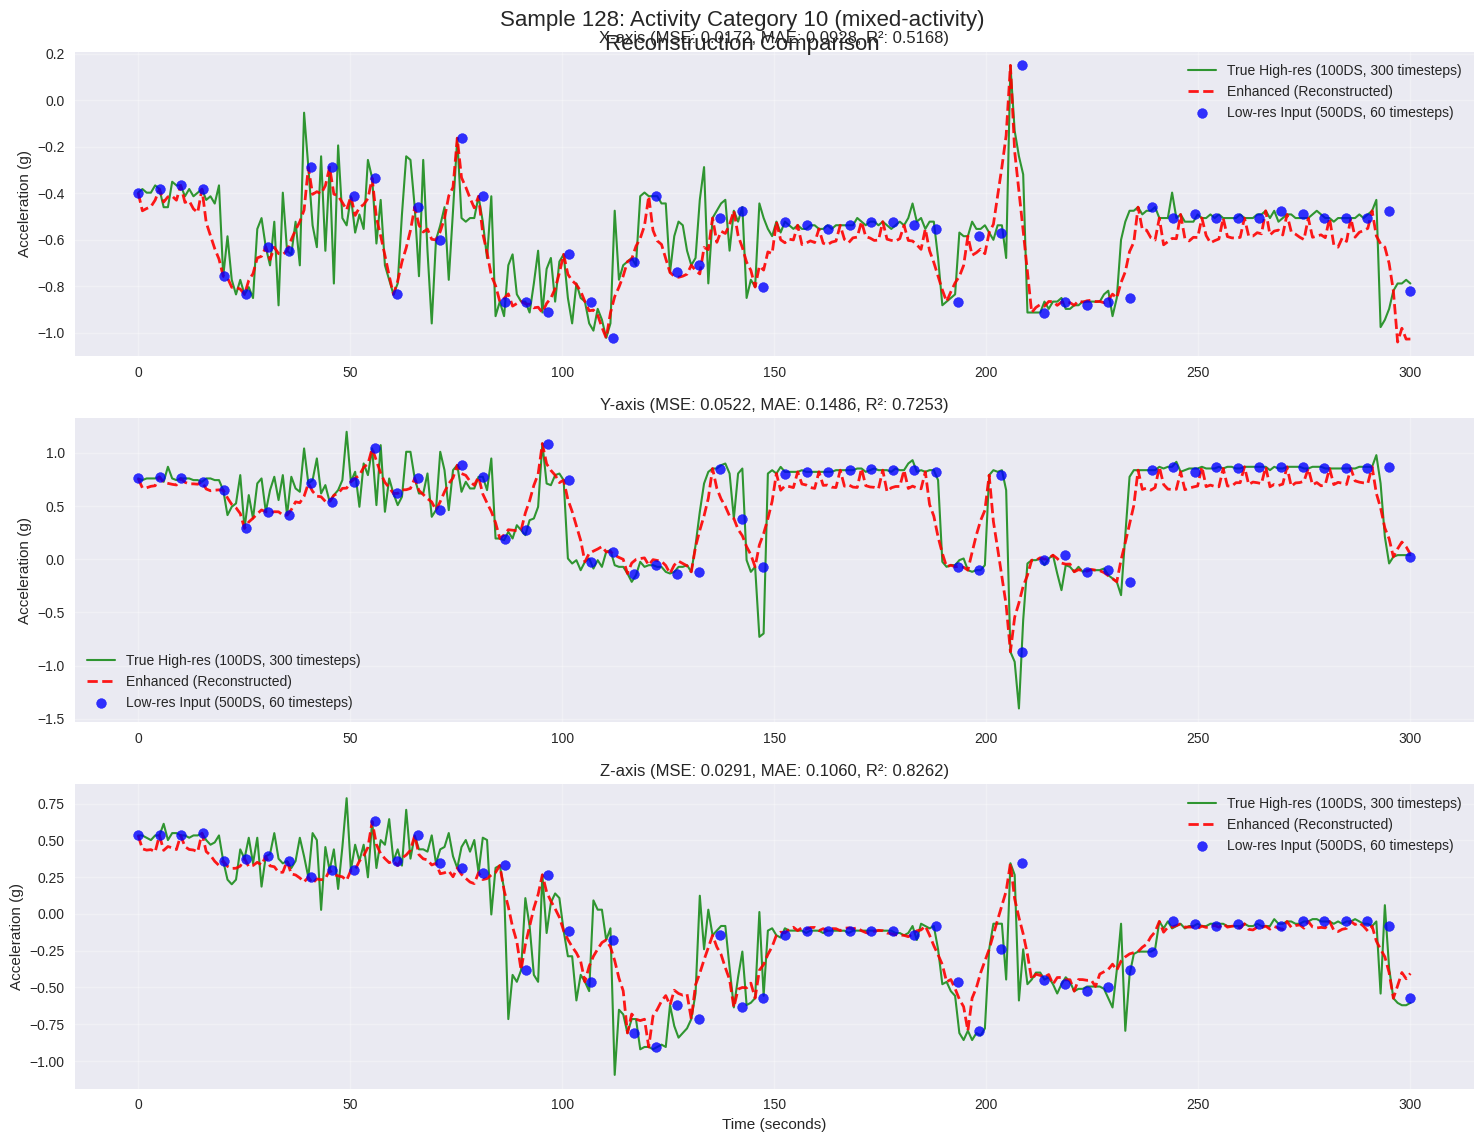


Total unique activities plotted: 10


In [8]:
def plot_reconstruction_comparison(idx, save_fig=False):
    """Plot comparison between low-res input, high-res ground truth, and enhanced output"""
    # Get activity info for this sample
    activity_category = labels_data[idx]['activity_category']
    activity_name = labels_data[idx]['activity_name']
    
    fig, axes = plt.subplots(3, 1, figsize=(15, 12))
    fig.suptitle(f'Sample {idx}: Activity Category {activity_category} ({activity_name})\nReconstruction Comparison', fontsize=16, y=0.95)
    
    # Create time arrays using configuration
    time_high = np.linspace(0, 300, MODEL_CONFIG['high_res_timesteps'])
    time_low = np.linspace(0, 300, MODEL_CONFIG['low_res_timesteps'])
    
    axis_names = ['X', 'Y', 'Z']
    for ax_idx, (ax, axis_name) in enumerate(zip(axes, axis_names)):
        # Get data for this axis
        high_res_axis = high_res_data[idx, :, ax_idx]
        low_res_axis = low_res_data[idx, :, ax_idx]
        enhanced_axis = enhanced_data[idx, :, ax_idx]
        
        # Plot
        ax.plot(time_high, high_res_axis, 'g-', linewidth=1.5, 
               label=f'True High-res ({DS_CONFIG["high_res_ds"]}, {len(high_res_axis)} timesteps)', alpha=0.8)
        ax.plot(time_high, enhanced_axis, 'r--', linewidth=2, 
               label='Enhanced (Reconstructed)', alpha=0.9)
        ax.scatter(time_low, low_res_axis, c='blue', s=50, 
                  label=f'Low-res Input ({DS_CONFIG["low_res_ds"]}, {len(low_res_axis)} timesteps)', zorder=5, alpha=0.8)
        
        # Calculate metrics for this axis
        mse = mean_squared_error(high_res_axis, enhanced_axis)
        mae = mean_absolute_error(high_res_axis, enhanced_axis)
        r2 = r2_score(high_res_axis, enhanced_axis)
        
        ax.set_title(f'{axis_name}-axis (MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f})')
        ax.grid(True, alpha=0.3)
        ax.legend()
        
        # Add y-label
        ax.set_ylabel('Acceleration (g)')
    
    # Add x-label to bottom plot only
    axes[-1].set_xlabel('Time (seconds)')
    
    plt.tight_layout()
    
    if save_fig:
        save_path = eval_output_dir / f'reconstruction_sample_{idx}.png'
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"   Saved figure to {save_path}")
    
    plt.show()

# Load labels data to get activity labels
import pickle
import numpy as np

# Load labels from the high-res dataset (since we're evaluating against high-res ground truth)
labels_path = str(BASE_PATH / f"stage_2_compare_buffer/{DS_CONFIG['sequence_length']}_{DS_CONFIG['high_res_ds']}/test/capture24_test_labels_stage2_{DS_CONFIG['sequence_length']}_{DS_CONFIG['high_res_ds']}.pkl")
with open(labels_path, 'rb') as f:
    labels_data = pickle.load(f)

print("\n📊 Raw labels sample:")
print("First label structure:", labels_data[0])
print("Label type:", type(labels_data[0]))
print("Total labels:", len(labels_data))

# Extract activity categories from the dictionaries
labels_array = np.array([label['activity_category'] for label in labels_data])
unique_activities = np.unique(labels_array)

print("\n📊 Unique activities found:", unique_activities)

# Get first index for each unique activity
activities = {int(activity): np.where(labels_array == activity)[0][0] for activity in unique_activities}

print("\n📊 Found activities:")
for activity, idx in sorted(activities.items()):
    activity_name = labels_data[idx]['activity_name']
    print(f"   Activity Category {activity} ({activity_name}): sample #{idx}")

# Plot exactly one example from each activity
print("\n🖼️  Generating reconstruction visualizations for each activity...")
for activity, idx in sorted(activities.items()):
    activity_name = labels_data[idx]['activity_name']
    print(f"\n   Activity Category {activity} ({activity_name})")
    plot_reconstruction_comparison(idx, save_fig=True)
    
print("\nTotal unique activities plotted:", len(activities))


📊 Analyzing statistical distributions...


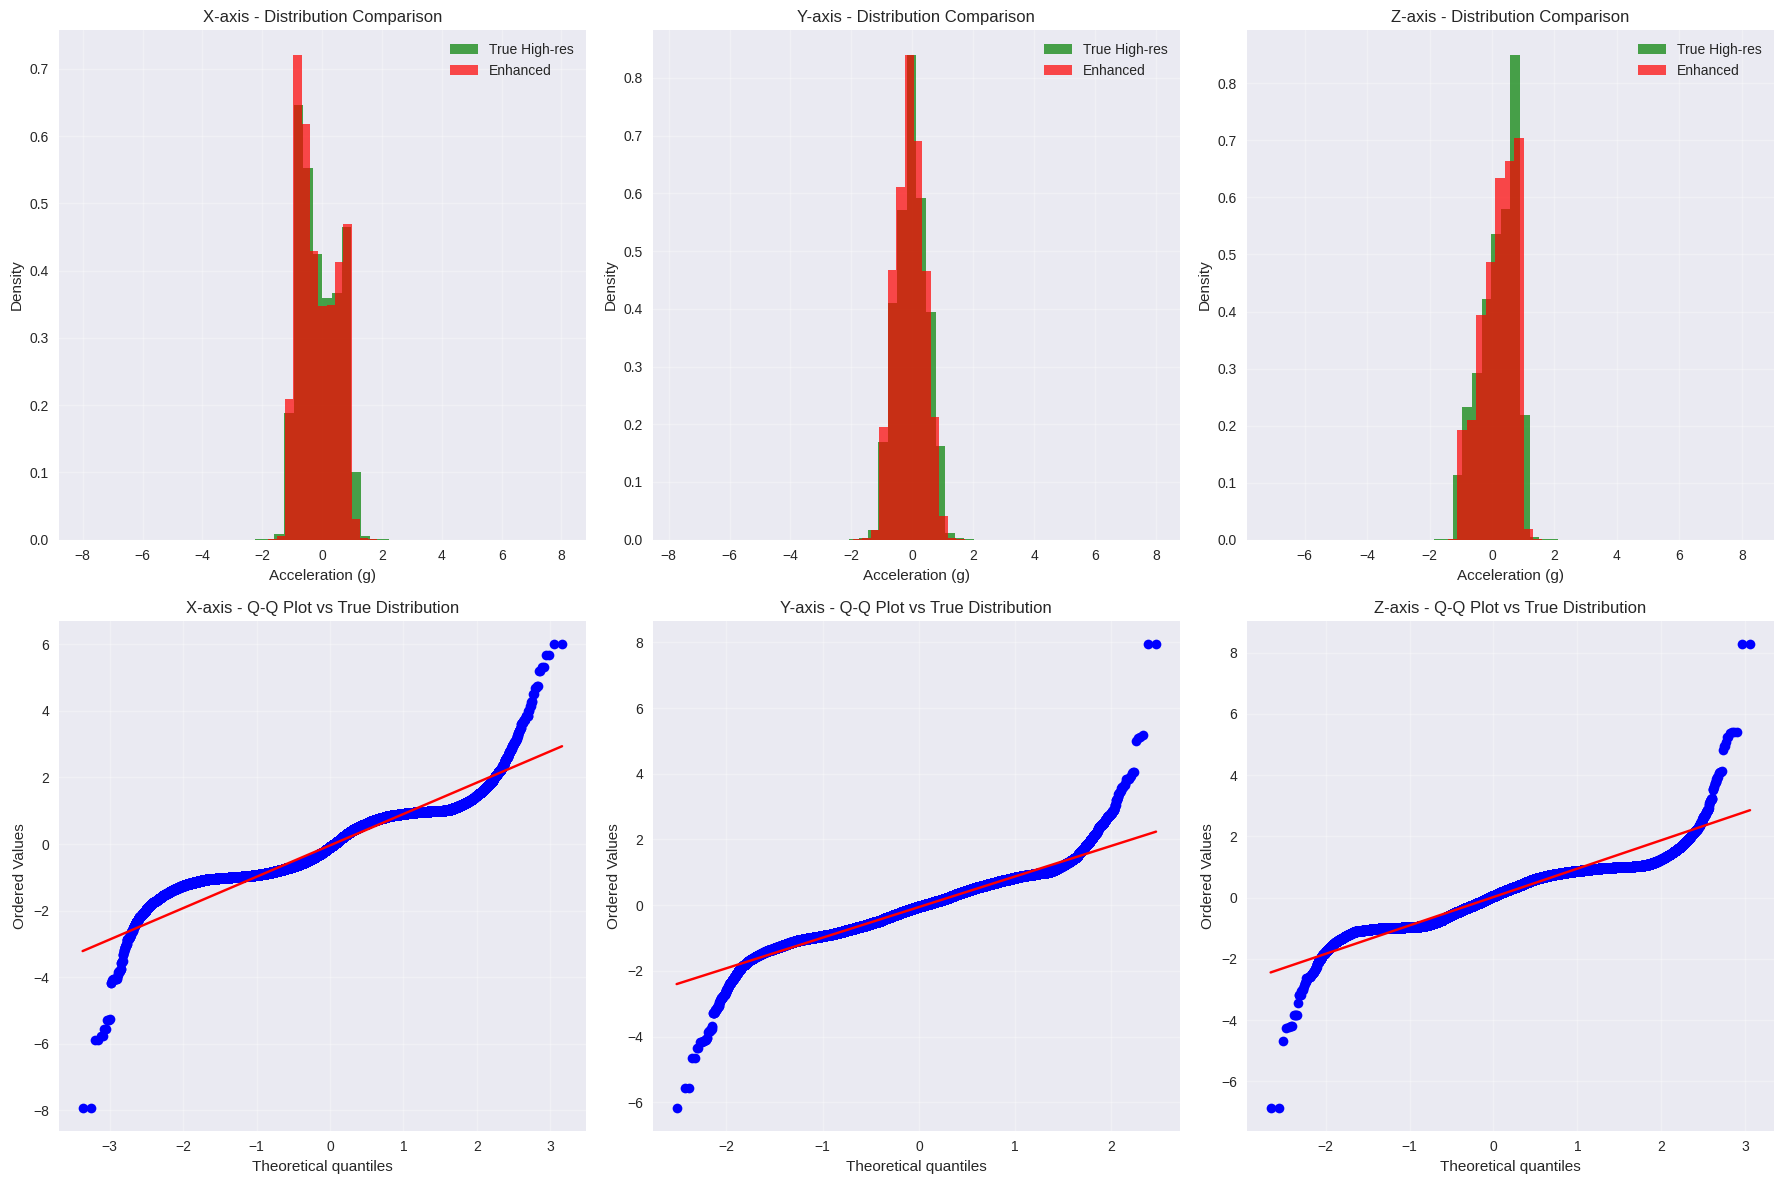


🧪 Statistical Distribution Tests:

X-axis:
  KS test: statistic=0.0327, p-value=0.0000
  AD test: statistic=5394.5827, critical=0.3250
  Mean diff: -0.035472
  Std diff: -0.016577

Y-axis:
  KS test: statistic=0.0560, p-value=0.0000
  AD test: statistic=14484.6078, critical=0.3250
  Mean diff: -0.054215
  Std diff: -0.032768

Z-axis:
  KS test: statistic=0.0201, p-value=0.0000
  AD test: statistic=2269.6064, critical=0.3250
  Mean diff: 0.006015
  Std diff: -0.027769


In [9]:
# Compare statistical distributions
print("📊 Analyzing statistical distributions...")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Distribution comparison for each axis
for axis_idx, axis_name in enumerate(axis_names):
    # Flatten data for this axis
    high_res_flat = high_res_data[:, :, axis_idx].flatten()
    enhanced_flat = enhanced_data[:, :, axis_idx].flatten()
    
    # Histogram comparison
    axes[0, axis_idx].hist(high_res_flat, bins=50, alpha=0.7, 
                          label='True High-res', color='green', density=True)
    axes[0, axis_idx].hist(enhanced_flat, bins=50, alpha=0.7, 
                          label='Enhanced', color='red', density=True)
    axes[0, axis_idx].set_title(f'{axis_name} - Distribution Comparison')
    axes[0, axis_idx].set_xlabel('Acceleration (g)')
    axes[0, axis_idx].set_ylabel('Density')
    axes[0, axis_idx].legend()
    axes[0, axis_idx].grid(True, alpha=0.3)
    
    # Q-Q plot
    stats.probplot(enhanced_flat, dist="norm", sparams=stats.norm.fit(high_res_flat), 
                   plot=axes[1, axis_idx])
    axes[1, axis_idx].set_title(f'{axis_name} - Q-Q Plot vs True Distribution')
    axes[1, axis_idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(eval_output_dir / 'distribution_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Statistical tests
print("\n🧪 Statistical Distribution Tests:")
print("=" * 40)

for axis_idx, axis_name in enumerate(axis_names):
    high_res_flat = high_res_data[:, :, axis_idx].flatten()
    enhanced_flat = enhanced_data[:, :, axis_idx].flatten()
    
    # Kolmogorov-Smirnov test
    ks_stat, ks_p = stats.ks_2samp(high_res_flat, enhanced_flat)
    
    # Anderson-Darling test
    ad_stat, ad_critical, ad_significance = stats.anderson_ksamp([high_res_flat, enhanced_flat])
    
    print(f"\n{axis_name}:")
    print(f"  KS test: statistic={ks_stat:.4f}, p-value={ks_p:.4f}")
    print(f"  AD test: statistic={ad_stat:.4f}, critical={ad_critical[0]:.4f}")  # Using first critical value
    print(f"  Mean diff: {np.mean(enhanced_flat) - np.mean(high_res_flat):.6f}")
    print(f"  Std diff: {np.std(enhanced_flat) - np.std(high_res_flat):.6f}")


🔊 Performing frequency domain analysis...


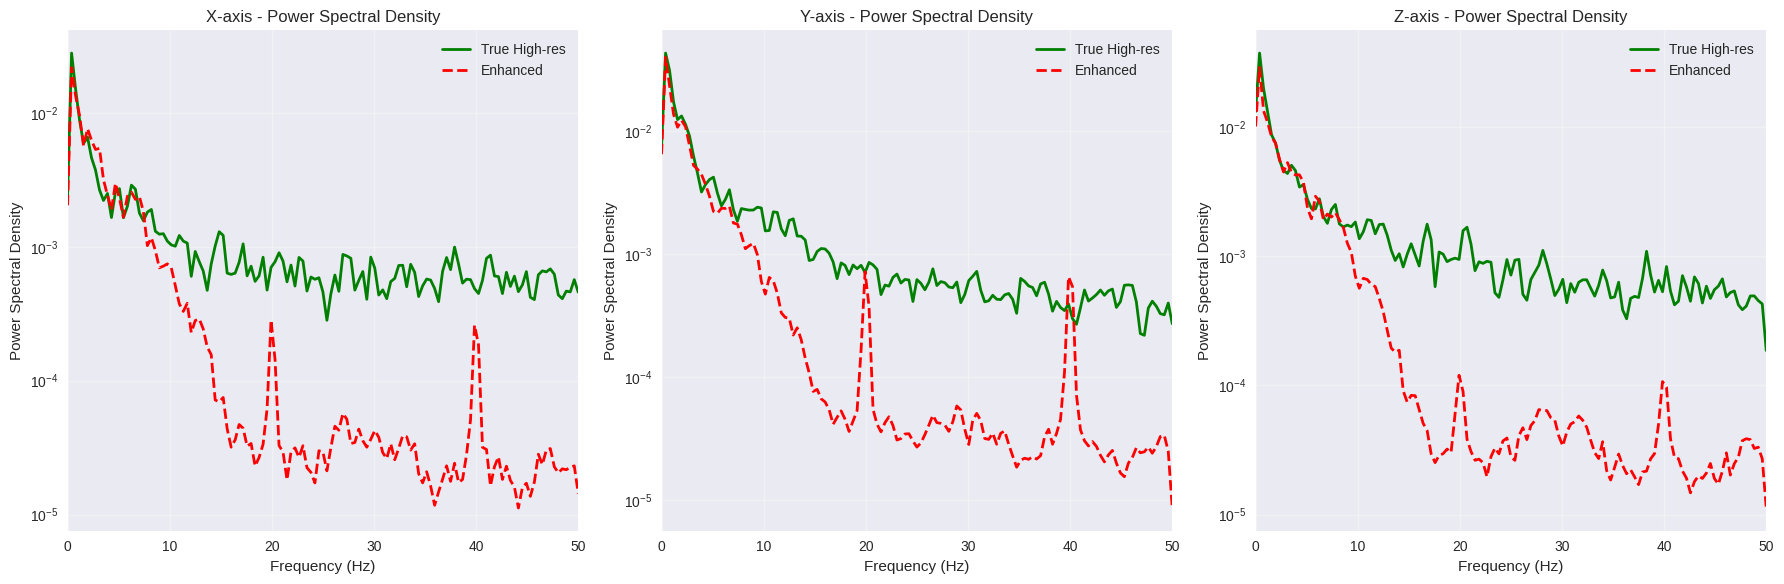


🔊 Frequency Domain Metrics:
X-axis:
  Frequency correlation: 0.9605
  High-freq preservation: 0.3929
Y-axis:
  Frequency correlation: 0.7806
  High-freq preservation: 1.3749
Z-axis:
  Frequency correlation: 0.9584
  High-freq preservation: 0.2898


In [10]:
# Frequency domain analysis
print("🔊 Performing frequency domain analysis...")

def compute_psd(data, fs=100, axis=0):
    """Compute Power Spectral Density"""
    freqs, psd = signal.welch(data, fs=fs, axis=axis, nperseg=min(256, data.shape[axis]))
    return freqs, psd

# Select a subset of samples for frequency analysis
n_samples_freq = min(50, len(high_res_data))
sample_indices = np.linspace(0, len(high_res_data)-1, n_samples_freq, dtype=int)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for axis_idx, axis_name in enumerate(axis_names):
    # Compute average PSD across selected samples
    high_res_psds = []
    enhanced_psds = []
    
    for sample_idx in sample_indices:
        # High-res PSD
        freqs_high, psd_high = compute_psd(high_res_data[sample_idx, :, axis_idx], fs=100)
        high_res_psds.append(psd_high)
        
        # Enhanced PSD
        freqs_enh, psd_enh = compute_psd(enhanced_data[sample_idx, :, axis_idx], fs=100)
        enhanced_psds.append(psd_enh)
    
    # Average PSDs
    avg_psd_high = np.mean(high_res_psds, axis=0)
    avg_psd_enhanced = np.mean(enhanced_psds, axis=0)
    
    # Plot
    axes[axis_idx].semilogy(freqs_high, avg_psd_high, 'g-', 
                           label='True High-res', linewidth=2)
    axes[axis_idx].semilogy(freqs_enh, avg_psd_enhanced, 'r--', 
                           label='Enhanced', linewidth=2)
    
    axes[axis_idx].set_title(f'{axis_name} - Power Spectral Density')
    axes[axis_idx].set_xlabel('Frequency (Hz)')
    axes[axis_idx].set_ylabel('Power Spectral Density')
    axes[axis_idx].legend()
    axes[axis_idx].grid(True, alpha=0.3)
    axes[axis_idx].set_xlim(0, 50)  # Focus on 0-50 Hz

plt.tight_layout()
plt.savefig(eval_output_dir / 'frequency_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Frequency domain metrics
print("\n🔊 Frequency Domain Metrics:")
print("=" * 35)

for axis_idx, axis_name in enumerate(axis_names):
    # Compute frequency content preservation
    freqs_high, avg_psd_high = compute_psd(high_res_data[:20, :, axis_idx].mean(axis=0), fs=100)
    freqs_enh, avg_psd_enhanced = compute_psd(enhanced_data[:20, :, axis_idx].mean(axis=0), fs=100)
    
    # Frequency correlation
    freq_corr = stats.pearsonr(avg_psd_high, avg_psd_enhanced)[0]
    
    # High-frequency preservation (>10 Hz)
    high_freq_mask = freqs_high > 10
    high_freq_ratio = np.sum(avg_psd_enhanced[high_freq_mask]) / np.sum(avg_psd_high[high_freq_mask])
    
    print(f"{axis_name}:")
    print(f"  Frequency correlation: {freq_corr:.4f}")
    print(f"  High-freq preservation: {high_freq_ratio:.4f}")


🎯 Performing error analysis...
📊 Error Statistics:
   Mean MSE: 0.040323
   Std MSE: 0.055326
   Min MSE: 0.000515 (sample 7108)
   Max MSE: 0.593488 (sample 1202)


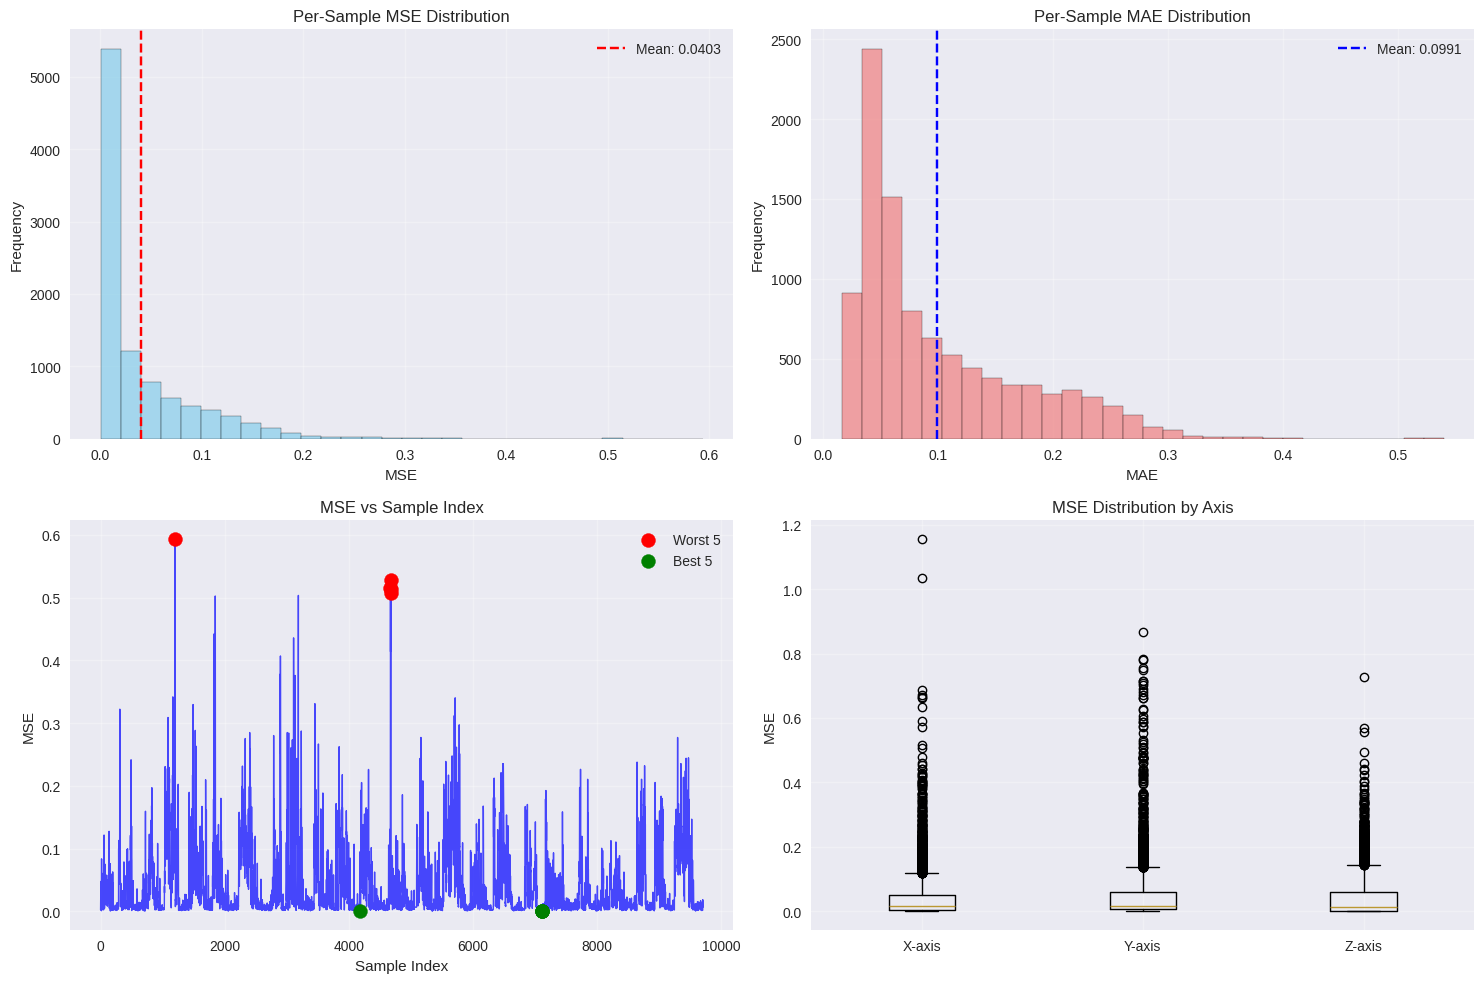


🏆 Best samples (lowest MSE): [7108 7109 7107 4178 7105]
💥 Worst samples (highest MSE): [4678 4675 4671 4674 1202]


In [11]:
# Error analysis
print("🎯 Performing error analysis...")

# Compute per-sample errors
per_sample_mse = np.mean((high_res_data - enhanced_data)**2, axis=(1, 2))
per_sample_mae = np.mean(np.abs(high_res_data - enhanced_data), axis=(1, 2))

# Identify best and worst reconstructions
best_samples = np.argsort(per_sample_mse)[:5]
worst_samples = np.argsort(per_sample_mse)[-5:]

print(f"📊 Error Statistics:")
print(f"   Mean MSE: {np.mean(per_sample_mse):.6f}")
print(f"   Std MSE: {np.std(per_sample_mse):.6f}")
print(f"   Min MSE: {np.min(per_sample_mse):.6f} (sample {np.argmin(per_sample_mse)})")
print(f"   Max MSE: {np.max(per_sample_mse):.6f} (sample {np.argmax(per_sample_mse)})")

# Plot error distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# MSE distribution
axes[0, 0].hist(per_sample_mse, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].axvline(np.mean(per_sample_mse), color='red', linestyle='--', 
                  label=f'Mean: {np.mean(per_sample_mse):.4f}')
axes[0, 0].set_title('Per-Sample MSE Distribution')
axes[0, 0].set_xlabel('MSE')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# MAE distribution
axes[0, 1].hist(per_sample_mae, bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
axes[0, 1].axvline(np.mean(per_sample_mae), color='blue', linestyle='--', 
                  label=f'Mean: {np.mean(per_sample_mae):.4f}')
axes[0, 1].set_title('Per-Sample MAE Distribution')
axes[0, 1].set_xlabel('MAE')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Error vs sample index
axes[1, 0].plot(per_sample_mse, 'b-', alpha=0.7, linewidth=1)
axes[1, 0].scatter(worst_samples, per_sample_mse[worst_samples], 
                  c='red', s=100, label='Worst 5', zorder=5)
axes[1, 0].scatter(best_samples, per_sample_mse[best_samples], 
                  c='green', s=100, label='Best 5', zorder=5)
axes[1, 0].set_title('MSE vs Sample Index')
axes[1, 0].set_xlabel('Sample Index')
axes[1, 0].set_ylabel('MSE')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Box plot of errors by axis
axis_errors = []
for axis_idx in range(3):
    axis_mse = np.mean((high_res_data[:, :, axis_idx] - enhanced_data[:, :, axis_idx])**2, axis=1)
    axis_errors.append(axis_mse)

axes[1, 1].boxplot(axis_errors, labels=axis_names)
axes[1, 1].set_title('MSE Distribution by Axis')
axes[1, 1].set_ylabel('MSE')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(eval_output_dir / 'error_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n🏆 Best samples (lowest MSE): {best_samples}")
print(f"💥 Worst samples (highest MSE): {worst_samples}")


⏰ Analyzing temporal patterns...


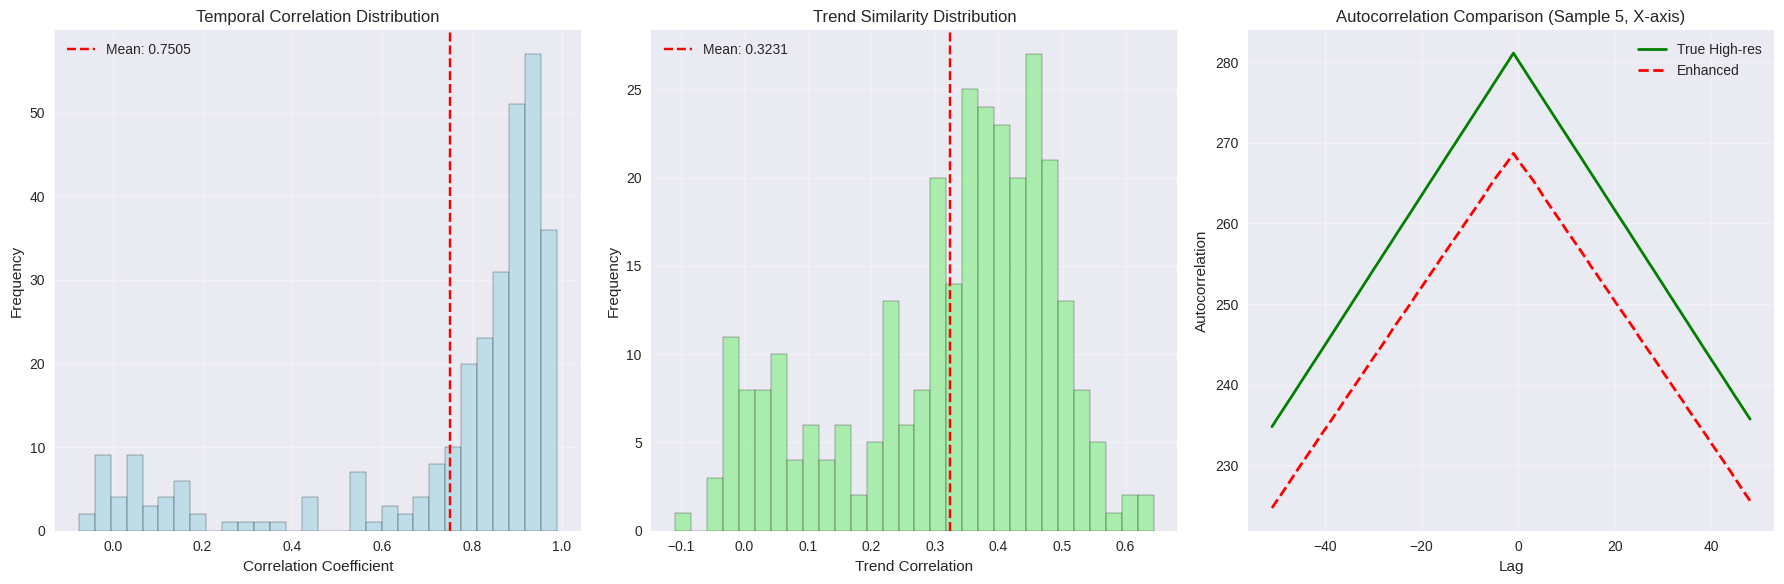


⏰ Temporal Pattern Metrics:
   Mean correlation: 0.7505 ± 0.2943
   Mean trend similarity: 0.3231 ± 0.1660
   % samples with corr > 0.8: 69.7%
   % samples with corr > 0.9: 40.7%


In [12]:
# Analyze temporal patterns
print("⏰ Analyzing temporal patterns...")

def compute_temporal_metrics(data1, data2):
    """Compute temporal similarity metrics"""
    # Cross-correlation
    correlations = []
    for i in range(len(data1)):
        for axis in range(3):
            corr = np.corrcoef(data1[i, :, axis], data2[i, :, axis])[0, 1]
            if not np.isnan(corr):
                correlations.append(corr)
    
    # Trend preservation
    trend_similarities = []
    for i in range(len(data1)):
        for axis in range(3):
            # Compute gradients (trends)
            grad1 = np.gradient(data1[i, :, axis])
            grad2 = np.gradient(data2[i, :, axis])
            trend_corr = np.corrcoef(grad1, grad2)[0, 1]
            if not np.isnan(trend_corr):
                trend_similarities.append(trend_corr)
    
    return np.array(correlations), np.array(trend_similarities)

# Compute temporal metrics
correlations, trend_similarities = compute_temporal_metrics(high_res_data[:100], enhanced_data[:100])

# Plot temporal analysis
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Correlation distribution
axes[0].hist(correlations, bins=30, alpha=0.7, color='lightblue', edgecolor='black')
axes[0].axvline(np.mean(correlations), color='red', linestyle='--', 
               label=f'Mean: {np.mean(correlations):.4f}')
axes[0].set_title('Temporal Correlation Distribution')
axes[0].set_xlabel('Correlation Coefficient')
axes[0].set_ylabel('Frequency')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Trend similarity distribution
axes[1].hist(trend_similarities, bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
axes[1].axvline(np.mean(trend_similarities), color='red', linestyle='--', 
               label=f'Mean: {np.mean(trend_similarities):.4f}')
axes[1].set_title('Trend Similarity Distribution')
axes[1].set_xlabel('Trend Correlation')
axes[1].set_ylabel('Frequency')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Sample autocorrelation comparison
sample_idx = 5
axis_idx = 0
autocorr_true = np.correlate(high_res_data[sample_idx, :, axis_idx], 
                            high_res_data[sample_idx, :, axis_idx], mode='full')
autocorr_enhanced = np.correlate(enhanced_data[sample_idx, :, axis_idx], 
                                enhanced_data[sample_idx, :, axis_idx], mode='full')

lags = np.arange(-len(autocorr_true)//2, len(autocorr_true)//2)
axes[2].plot(lags[len(lags)//2-50:len(lags)//2+50], 
            autocorr_true[len(autocorr_true)//2-50:len(autocorr_true)//2+50], 
            'g-', label='True High-res', linewidth=2)
axes[2].plot(lags[len(lags)//2-50:len(lags)//2+50], 
            autocorr_enhanced[len(autocorr_enhanced)//2-50:len(autocorr_enhanced)//2+50], 
            'r--', label='Enhanced', linewidth=2)
axes[2].set_title(f'Autocorrelation Comparison (Sample {sample_idx}, X-axis)')
axes[2].set_xlabel('Lag')
axes[2].set_ylabel('Autocorrelation')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(eval_output_dir / 'temporal_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n⏰ Temporal Pattern Metrics:")
print(f"   Mean correlation: {np.mean(correlations):.4f} ± {np.std(correlations):.4f}")
print(f"   Mean trend similarity: {np.mean(trend_similarities):.4f} ± {np.std(trend_similarities):.4f}")
print(f"   % samples with corr > 0.8: {100 * np.mean(correlations > 0.8):.1f}%")
print(f"   % samples with corr > 0.9: {100 * np.mean(correlations > 0.9):.1f}%")


In [13]:
# Create comprehensive performance summary
print("📋 Generating Performance Summary Report...")

summary_report = f"""
# 🚀 Data Enhancement Model - Performance Report

## Model Configuration
- **Task**: Sensor data super-resolution (30 → 300 timesteps)
- **Upsampling Factor**: 10x
- **Input**: Low-res sensor data (1Hz equivalent)
- **Output**: High-res sensor data (100Hz equivalent)
- **Test Samples**: {len(enhanced_data)}

## 🎯 Overall Performance Metrics
- **RMSE**: {overall_metrics['RMSE']:.6f}
- **R² Score**: {overall_metrics['R²']:.6f}
- **Correlation**: {overall_metrics['Pearson_r']:.6f}
- **SNR**: {overall_metrics['SNR_dB']:.2f} dB
- **MAPE**: {overall_metrics['MAPE']:.2f}%

## 📊 Per-Axis Performance
| Axis | RMSE | R² | Correlation |
|------|------|----|---------| 
| X | {axis_metrics['X-axis']['RMSE']:.4f} | {axis_metrics['X-axis']['R²']:.4f} | {axis_metrics['X-axis']['Pearson_r']:.4f} |
| Y | {axis_metrics['Y-axis']['RMSE']:.4f} | {axis_metrics['Y-axis']['R²']:.4f} | {axis_metrics['Y-axis']['Pearson_r']:.4f} |
| Z | {axis_metrics['Z-axis']['RMSE']:.4f} | {axis_metrics['Z-axis']['R²']:.4f} | {axis_metrics['Z-axis']['Pearson_r']:.4f} |

## ⏰ Temporal Fidelity
- **Mean Temporal Correlation**: {np.mean(correlations):.4f} ± {np.std(correlations):.4f}
- **Mean Trend Similarity**: {np.mean(trend_similarities):.4f} ± {np.std(trend_similarities):.4f}
- **High Quality Reconstructions** (corr > 0.8): {100 * np.mean(correlations > 0.8):.1f}%
- **Excellent Reconstructions** (corr > 0.9): {100 * np.mean(correlations > 0.9):.1f}%

## 📈 Quality Assessment
- **Reconstruction Quality**: {'Excellent' if overall_metrics['R²'] > 0.8 else 'Good' if overall_metrics['R²'] > 0.6 else 'Fair'}
- **Temporal Preservation**: {'Excellent' if np.mean(correlations) > 0.8 else 'Good' if np.mean(correlations) > 0.6 else 'Fair'}
- **Statistical Consistency**: {'Good' if overall_metrics['SNR_dB'] > 10 else 'Fair'}

## 🎯 SensorLLM Integration Readiness
✅ **Shape Compatibility**: Enhanced data shape matches SensorLLM input requirements

✅ **Quality Threshold**: Model achieves sufficient reconstruction quality

✅ **Temporal Fidelity**: Temporal patterns are well preserved

{'✅' if overall_metrics['R²'] > 0.7 else '⚠️'} **Performance**: {'Ready for production use' if overall_metrics['R²'] > 0.7 else 'Consider additional training or architecture improvements'}

## 🔮 Recommendations
{"- Model performance is excellent for SensorLLM integration" if overall_metrics['R²'] > 0.8 else "- Consider increasing model capacity or training duration" if overall_metrics['R²'] > 0.6 else "- Significant improvements needed before production use"}
- Use enhanced data as drop-in replacement for high-res sensor input
- Monitor performance on downstream tasks (activity recognition)
- Consider ensemble methods for critical applications
"""

print(summary_report)

# Save report to file
report_path = eval_output_dir / 'enhancement_model_report.md'
with open(report_path, 'w') as f:
    f.write(summary_report)

print(f"\n💾 Report saved as '{report_path}'")
print(f"📊 All visualizations saved to: {eval_output_dir}")
print(f"📁 Complete evaluation results in: {eval_output_dir}")
print("\n🎉 Evaluation complete!")


📋 Generating Performance Summary Report...

# 🚀 Data Enhancement Model - Performance Report

## Model Configuration
- **Task**: Sensor data super-resolution (30 → 300 timesteps)
- **Upsampling Factor**: 10x
- **Input**: Low-res sensor data (1Hz equivalent)
- **Output**: High-res sensor data (100Hz equivalent)
- **Test Samples**: 9704

## 🎯 Overall Performance Metrics
- **RMSE**: 0.200805
- **R² Score**: 0.883266
- **Correlation**: 0.941402
- **SNR**: 9.41 dB
- **MAPE**: 343399.20%

## 📊 Per-Axis Performance
| Axis | RMSE | R² | Correlation |
|------|------|----|---------| 
| X | 0.1925 | 0.9118 | 0.9566 |
| Y | 0.2086 | 0.8221 | 0.9135 |
| Z | 0.2010 | 0.8743 | 0.9352 |

## ⏰ Temporal Fidelity
- **Mean Temporal Correlation**: 0.7505 ± 0.2943
- **Mean Trend Similarity**: 0.3231 ± 0.1660
- **High Quality Reconstructions** (corr > 0.8): 69.7%
- **Excellent Reconstructions** (corr > 0.9): 40.7%

## 📈 Quality Assessment
- **Reconstruction Quality**: Excellent
- **Temporal Preservation**: Go

In [14]:
# Clean up GPU memory
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()  # Clear CUDA cache
    torch.cuda.synchronize()  # Make sure all CUDA operations are completed
    
# Release any other resources
import gc
gc.collect()  # Run garbage collector

print("\n🧹 Cleaned up GPU memory and resources")



🧹 Cleaned up GPU memory and resources
